In [1]:
from datetime import datetime as dt
start_time = dt.now()

***
# VIOLENT CRIME ANALYSIS DURING LOCKDOWN 2020 IN THE UNITED KINGDOM
***

***
## INTRODUCTION
***
COVID-19 has been recognized as a global public health concern as well as a public health threat (Das, Das and Ghosh, 2020). To stop the virus from spreading, the United Kingdom (UK) imposed tight 'lockdown' restrictions, requiring the majority of the people to stay at home. Lockdowns, according to Poblete-Cazenave, (2020), may exacerbate domestic violence for a variety of reasons, including forced cohabitation of offenders and victims in the same location and high levels of economic stress due to restricted job options and financial difficulty.

The impact of the Covid-19 epidemic on violence against women and children has been quantified by an increasing body of studies. The findings are mixed, with some research indicating an increase, others indicating the opposite in domestic violence. The majority of these research are based on time series analysis of crime (Arenas-Arroyo, Fernandez-Kranz and Nollenberger, 2021). The fact that these data sets are based on reported events is a limitation, but it is well-known that domestic violence has a significant misreporting problem, which could be exacerbated during a lockdown if victims,  believe they don't have access to support services in the health, police, and justice departments (Peterman et al, 2020).

***
## AIM
***
The aim of this project is to verify if the lockdown caused an overall increase in recorded violent crime, due to the possible increase in domestic violence during lockdowns.

There are two main datasets used in this project. First is the 'all_crimes21' containing approximately 65million reported and registered crimes from 2010-2021. Second is the 'LSOA_pop' dataset containing approximately 35 thousand location observations.

*** 
## ANALYSIS 
***
The analysis is done by filtering the 'all_crimes21' dataset to create one only with 'Violence and Sexual Offences' and then use present data to predict the rate/level of voilent crimes during UK's lockdown period which started in March, 2020. This category is used only as a result of the change of title in 2013, the previous title was 'Violent Crime'.

The same model used for prediction is then used to predict violent crime rates in Leicester City for the period of their lockdown which starts in July, 2020.

To conduct analysis, Spark dataframes, SparkSql, and Pandas are used in conjunction.

In [2]:
import numpy as np #to perform mathematical operations on arrays
import pandas as pd #for data manipulation and analysis

import warnings #to show warning messages
warnings.filterwarnings("ignore") # specify to ignore warning messages

import itertools #functions to produce complex iterators

import seaborn as sns; sns.set_theme() #visualisation of statistical graphs
import matplotlib.pyplot as plt #for data visualization

from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, sum, col, to_date

import statsmodels.api as sm #for specifying models using formula strings and dataframes

from pyspark.sql.functions import substring, length, col, expr
import pyspark.sql.functions as func

In [3]:
spark = SparkSession\
.builder\
.appName("Violent Crime Analysis")\
.getOrCreate()

#Checking for spark context: shows spark version and app name

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Violent Crime Analysis>

In [4]:
#loading all_crimes data into a dataframe.

allcrimes_url = "http://unn-izje1.newnumyspace.co.uk/all_crimes21_hdr.txt.gz"
spark.sparkContext.addFile(allcrimes_url)

***
A DataFrame is a two-dimensional labelled data structure with multiple sorts of columns. It is used because it makes data flexible and customizable.

A personal Schema is created and used to update the dataframe for easy retention and querying.
***

In [5]:
#Defining a new schema rather than using the one inferred 
ACschema = StructType(
    [
        StructField('CrimeID', StringType(),False),
        StructField('Month', StringType(),False),
        StructField('ReportedBy', StringType(),False),
        StructField('FallsWithin', StringType(),False),
        StructField('Longitude', StringType(),False),
        StructField('Latitude', StringType(),False),
        StructField('Location', StringType(),False),
        StructField('LSOACode', StringType(),False),
        StructField('LSOAName', StringType(),False),
        StructField('CrimeType', StringType(),False),
        StructField('LastOutcomeCat', StringType(),False),
        StructField('Context', StringType(),False)
    ]
)

In [6]:
#loading dataframe with new schema
AC_df = spark.read.csv("file://" + SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, schema= ACschema)

In [7]:
AC_df.printSchema() #prints schema

root
 |-- CrimeID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- ReportedBy: string (nullable = true)
 |-- FallsWithin: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOACode: string (nullable = true)
 |-- LSOAName: string (nullable = true)
 |-- CrimeType: string (nullable = true)
 |-- LastOutcomeCat: string (nullable = true)
 |-- Context: string (nullable = true)



***
The code below is used to create a new dataframe from the *AC_df* which holds the different crime types and how many times they have occurred.
***

In [8]:
AC_df_crime = (AC_df
            .select('CrimeType')
            .groupBy('CrimeType')
            .count()
            .orderBy('count')) #orders the crimetypes by count 

In [9]:
Ac_df_month_max = AC_df.groupby('CrimeType').agg({'Month':'max'}) #date when crimes were last reported

New dataframes holding the dates of when the crime categories were first and last used is created.

In [10]:
Ac_df_month_min = AC_df.groupby('CrimeType').agg({'Month':'min'}) #date when crimes were first reported

***
The table below shows the 16 different **crime categories** used by the police, as well as the number of reported and logged incidents for each category and the dates when crimes in the different categories were first and last reported.
***

In [11]:
AC_df_crimemonth = Ac_df_month_min.join(Ac_df_month_max, on = 'CrimeType') #joining the first reported dataframe with the last reported dataframe
(AC_df_crime.join(AC_df_crimemonth, on = 'CrimeType').show(truncate = False)) #joins the crime dataset to the crimemonth dataset on 'crimetype'

+----------------------------+--------+----------+----------+
|CrimeType                   |count   |min(Month)|max(Month)|
+----------------------------+--------+----------+----------+
|Bicycle theft               |735689  |2013-05   |2021-05   |
|Public order                |2564695 |2013-05   |2021-05   |
|Drugs                       |1682486 |2011-09   |2021-05   |
|Public disorder and weapons |242145  |2011-09   |2013-04   |
|Other crime                 |2565111 |2010-12   |2021-05   |
|Robbery                     |696008  |2010-12   |2021-05   |
|Criminal damage and arson   |5343182 |2011-09   |2021-05   |
|Theft from the person       |714621  |2013-05   |2021-05   |
|Shoplifting                 |3227557 |2011-09   |2021-05   |
|Burglary                    |4350252 |2010-12   |2021-05   |
|Violent crime               |1673219 |2010-12   |2013-04   |
|Other theft                 |5206259 |2011-09   |2021-05   |
|Possession of weapons       |283189  |2013-05   |2021-05   |
|Violenc

In [12]:
AC_df_crimemonth=[] #empties the dataframe as it would no longer be in use, helps in memory optimisation.

***
In September 2011, the category 'public disorder and weapons' was used, however it was modified to 'public order' in May 2013. This is the same for *'Violent crimes,'* which was used from December 2010 to April 2013, but then changed to *'Violence and sexual offences,'*  in May 2013.

 **This demonstrates that the categories have not been consistently used.**

The name change of the violent crime category has been taken as a reason to work with just the *'Violence and Sexual Offences'* category. Also, the weight of data in that category is enough to train our model and perform predictive analysis required in this project.

A new dataframe for just *'Violence and Sexual Offences'* is created so that further analysis can be done to find out if crime levels increased, decreased or remained constant.
***

In [13]:
#creating a dataframe that holds information only on Violence and sexual offences'
AC_df_vc = (AC_df
            .select('CrimeType', 'Month')
            .where(AC_df_crime.CrimeType == 'Violence and sexual offences')
            .groupBy('Month')
            .agg(count('CrimeType').alias('Rate'))
            .orderBy('Month'))

***
The *'Violence and Sexual Offences'*  dataframe is converted to a Pandas dataframe because a Pandas dataframe handles large datasets efficiently and is used to easily analyze data.
***

In [14]:
ViolentCrimes_pd = AC_df_vc.toPandas() #converting dataframe to a Pandas dataframe

***
Pandas time series is a time-based indexing technique that uses dates and times to conveniently arrange and access our data (Nielsen, 2019). We can utilise *datetime* formatted strings to select data in our dataframe with time-based indexing. The 'Month' column is converted to a Pandas datetime object column
***

In [15]:
ViolentCrimes_pd.Month = ViolentCrimes_pd.Month.astype('datetime64[ns]') #used to convert strings to datetime objects
ViolentCrimes_pd = ViolentCrimes_pd.set_index(pd.to_datetime(ViolentCrimes_pd.Month))

In [16]:
ViolentCrimes_pd = ViolentCrimes_pd.loc['2014-01-01':] #starts the series from 2014 because 2013 does not show adequate variations

***
Below, is the graph of violent crime rate plotted against time to show the general trend of crime occurence.

From 2014 through to 2021, there is an overall increase in crime levels, with minor dips in intervals mostly after July. It is however different for 2020 as a significant decrease in crime rates is seen from March to April 2020 when the lockdown starts, but then a substantial increase starts to occur till July(first Lockdown comes to an end on the 3rd of July) and from August it starts to fall again till early 2021, where there was a rise in rates.

Therefore, **Violent crime levels have not been constant**.
***

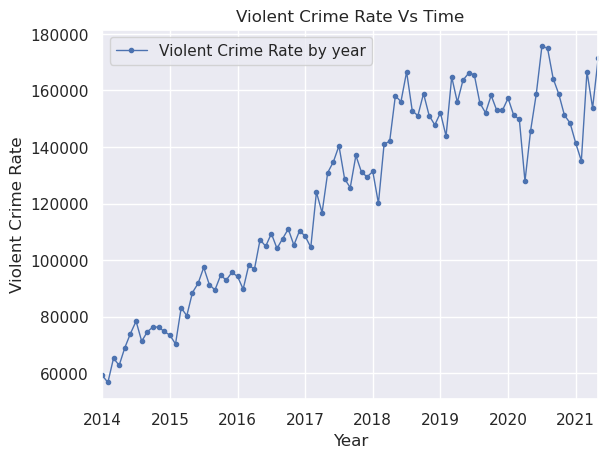

In [17]:
plt.figsize=(20, 6)

ViolentCrimes_pd.plot(y='Rate', x='Month',marker='.', linestyle='-', linewidth=1, subplots=False,
              label='Violent Crime Rate by year',
              title='Violent Crime Rate Vs Time') #plots crime rates on the y-axis and Month on the x-axis
plt.ylabel('Violent Crime Rate') #y-axis label
plt.xlabel('Year') #y-axis label

plt.show() #displays graph

***
When forecasting, it's recommended to utilise a 'seasonally-adjusted' time series, which simply removes the seasonal component. This enables the  forecaster to concentrate on predicting the data's general trend (Montgomery, Jennings and Kulahci, 2015).

The concept of time series decomposition is done to identify the behaviour in the seasonal component (Theodosiou, 2011). It divides a time series into multiple components, each expressing an underlying pattern category, trend, seasonality, and residual.

* Seasonality is the term used to characterise the periodic signal in a time series.
* Trend of a time series describes whether it is declining, constant, or growing with time.
* Residual is the term used to describe what remains after seasonality and trend have been removed from a time series. 

A **'multiplicative'** model is used because the seasonal component changes over time.
***

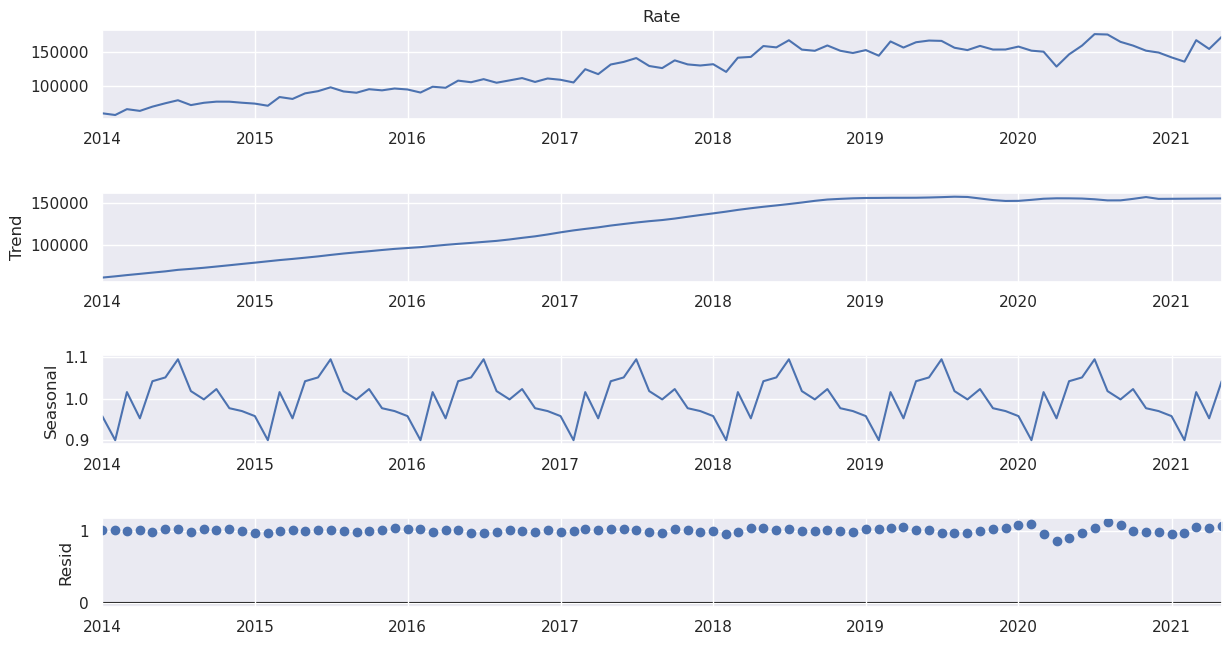

In [18]:
VC_decomposition = sm.tsa.seasonal_decompose(ViolentCrimes_pd['Rate'], model='multiplicative',extrapolate_trend='freq')
fig = VC_decomposition.plot()
fig.set_size_inches(14,7)
plt.show() #displays the graph

***
Stationarity refers to the fact that the statistical features of a time series are independent of the time at which it is observed (Busetti and Taylor, 2004). Trends and sesonality affect the value of the time series at different times, therefore they must be removed before the series can be considered stationary.

A **rolling statistic test for stationarity** is a pictorial representation of data that is used to determine if it is stationary. A moving average/rolling mean graph is plotted, and is then assessed to see if it changes over time (Chiarella, He and Hommes, 2006). The time series is not stationary if the graph of rolling mean and rolling standard deviation is not constant; otherwise, it is.
***

In [19]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean() 
    rolstd = pd.Series(timeseries).rolling(window=4).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling standard deviation (x10)');
    ax.legend()
    plt.show()

***
Chiarella, He and Hommes (2006) define a *moving average* as a statistical technique for analysing data points that involves calculating a series of averages from different subsets of the entire data set. It is used to eliminate short-term fluctuations and expose the signal of the underlying causal processes.

A moving average necessitates the specification of a window size known as the window width. The amount of raw observations utilised to generate the moving average value is specified here. The "moving" aspect of the moving average refers to how the window indicated by the window width is slid along the time series to calculate the new series' average values. A window width of 4 would be  used throughout the analysis.

From the graph below, it is seen that the rolling mean and rolling standard deviation is not constant, so it can be said that the time series is not stationary.
***

<Figure size 640x480 with 0 Axes>

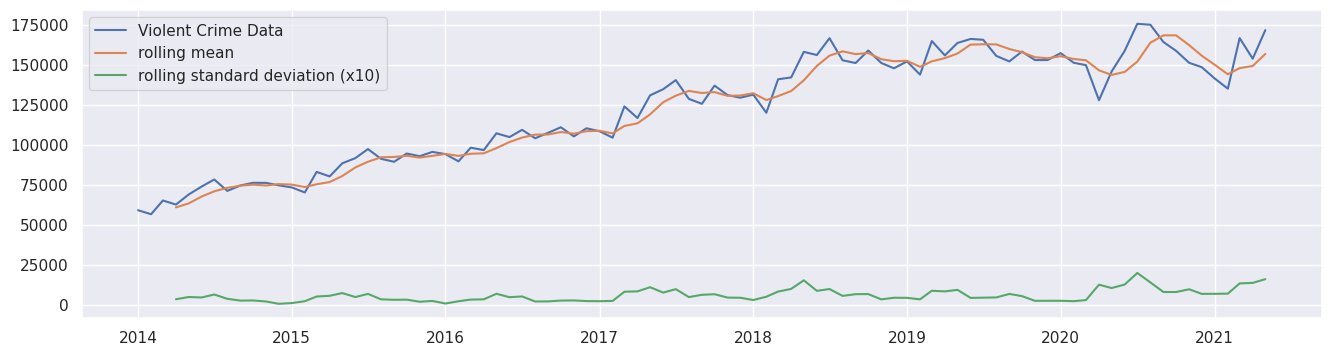

In [20]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(ViolentCrimes_pd['Rate'],'Violent Crime Data')

***
Another common statistical test for determining whether or not a time series is stationary is the **ADF Test (Augmented Dickey Fuller Test)**. The test statistic and p-value indicate whether or not the data is stationary. The test statistic should be less than the critical values, and the p-value should be less than 0.05, which is the significance level (Chang, Hsu and Wang, 2021).

The test results show that the test-statistic is -1.757, which is greater than all of the critical values, and the p-value obtained is 0.402, which is greater than the significance level. The time series is then determined to be non-stationary.
***

In [21]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
        

        
ADF_test(ViolentCrimes_pd['Rate'],'raw data')

 > Is the raw data stationary ?
Test statistic = -1.769
P-value = 0.396
Critical values :
	1%: -3.5194805351545413 - The data is not stationary with 99% confidence
	5%: -2.9003945086747343 - The data is not stationary with 95% confidence
	10%: -2.5874984279778395 - The data is not stationary with 90% confidence


***
**Detrending**, as a means of changing a time series' stationary nature, entails removing the effects of trend from a data set and displaying just the values that diverge from the trend (Schüler, 2018).

Tests for stationarity are applied again and it is seen that the series is still not in the state of stationarity with a tests-statistic higher than the critical values and a p-value greater than the significant value.
***

<Figure size 640x480 with 0 Axes>

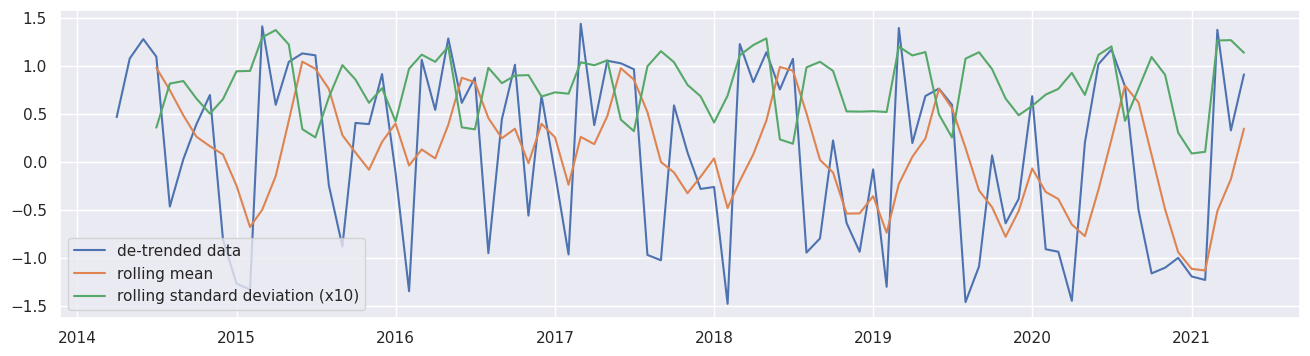

 > Is the de-trended data stationary ?
Test statistic = -1.069
P-value = 0.727
Critical values :
	1%: -3.5219803175527606 - The data is not stationary with 99% confidence
	5%: -2.9014701097664504 - The data is not stationary with 95% confidence
	10%: -2.58807215485756 - The data is not stationary with 90% confidence


In [22]:
# Detrending
vc = ViolentCrimes_pd['Rate']
vc_detrend =  (vc - vc.rolling(window=4).mean())/vc.rolling(window=4).std()

test_stationarity(vc_detrend,'de-trended data')
ADF_test(vc_detrend,'de-trended data')

***
**Differencing** can help stabilise the average of a time series by removing or reducing trend and seasonality by removing variations in the level of the time series. Differencing is performed by subtracting the previous observation from the current observation (Amimour and Belaide, 2020).

From the results below, it is determined that the series is now stationary as the p-value is significantly less than the significant value and the test-statistic is also lower than the critical values.
***

<Figure size 640x480 with 0 Axes>

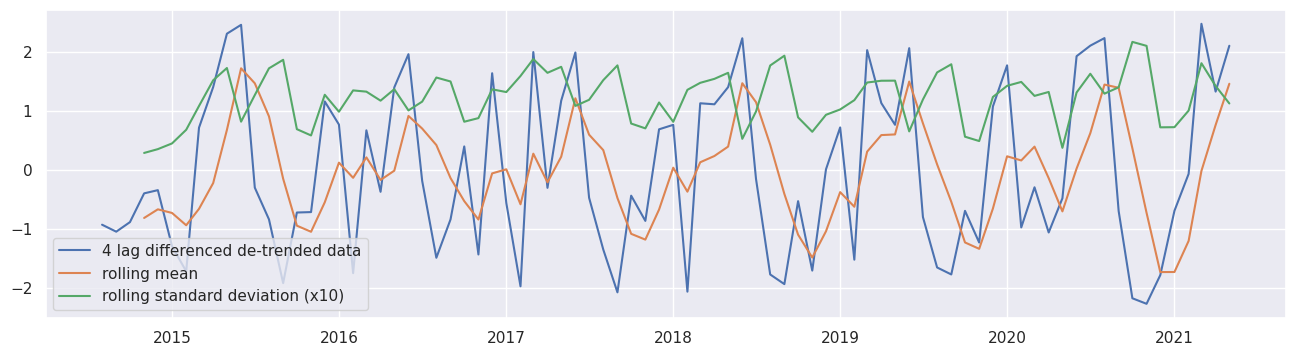

 > Is the 4 lag differenced de-trended data stationary ?
Test statistic = -5.299
P-value = 0.000
Critical values :
	1%: -3.5274258688046647 - The data is  stationary with 99% confidence
	5%: -2.903810816326531 - The data is  stationary with 95% confidence
	10%: -2.5893204081632653 - The data is  stationary with 90% confidence


In [23]:
# Detrending + Differencing

vc_4lag_detrend =  vc_detrend - vc_detrend.shift(4)

test_stationarity(vc_4lag_detrend,'4 lag differenced de-trended data')

ADF_test(vc_4lag_detrend,'4 lag differenced de-trended data')

In [24]:
dtrnd_vc = vc_4lag_detrend.dropna() #dropping missing values

Some values go missing after detrending, thus the code above is used to remove them.

***
### PREDICTING CRIME LEVELS FOR APRIL 2020
***

The *'Violence and Sexual Offences'* dataset is split up into two datasets for training and testing. The train set is made up of data on which the machine learns, it is from before the first lockdown i.e all data from inception of the category to March, 2020 while the testset is made up of data from after the lockdown starting from April, 2020. The testset is used to assess the machines capabilities. 


In [25]:
vc_to_train = dtrnd_vc[:'2020-03'] # dataset from before the lockdown to train
vc_to_test =dtrnd_vc['2020-04':] # dataset from april for test  
vc_to_val = vc_to_test 

***
SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) is an updated version of the ARIMA model which explicitly models the seasonal element in multivariate data and then predicts. ARIMA incorporates an autoregressive integrated moving average, whereas SARIMAX incorporates seasonal effects and eXogenous variables (Musbah and El-Hawary, 2019).

Parameters must be selected when building the model, which is accomplished through exhaustive iteration of the (p,d, q). P denotes the number of lag observations in the model, D denotes the number of times the raw observations are differenced, and Q denotes the size of the moving average window.
***

In [26]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

p = d = q = range(0, 2) #Define Parameter Ranges to Test 
seasonal_period = 4 #seasonal period of 4 is used as prediction is to be done for the period of the lockdown

pdq = list(itertools.product(p, d, q)) #Generate all different combinations of p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))] #Generate all different combinations of seasonal p, q and q triplets

***
A grid search was run with pdq and seasonal pdq parameters and get the best AIC value. The parameters with the lowest AIC value is chosen because a lower AIC values indicate a better-fit model (Bai, Choi and Fujikoshi, 2018).
***

In [27]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(vc_to_train, #timeseries
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit() #Fit the model
            print('ARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 4)4 - AIC:233.23009932338272
ARIMA(0, 0, 0)x(0, 0, 1, 4)4 - AIC:186.54190048994658
ARIMA(0, 0, 0)x(0, 1, 0, 4)4 - AIC:291.55054004180306
ARIMA(0, 0, 0)x(0, 1, 1, 4)4 - AIC:236.5310179194866
ARIMA(0, 0, 0)x(1, 0, 0, 4)4 - AIC:216.8333367750553
ARIMA(0, 0, 0)x(1, 0, 1, 4)4 - AIC:183.6211479890282
ARIMA(0, 0, 0)x(1, 1, 0, 4)4 - AIC:270.97311524827876
ARIMA(0, 0, 0)x(1, 1, 1, 4)4 - AIC:223.8695637621997
ARIMA(0, 0, 1)x(0, 0, 0, 4)4 - AIC:231.23977390863848
ARIMA(0, 0, 1)x(0, 0, 1, 4)4 - AIC:182.93571541253849
ARIMA(0, 0, 1)x(0, 1, 0, 4)4 - AIC:289.5637126185327
ARIMA(0, 0, 1)x(0, 1, 1, 4)4 - AIC:234.8457398430022
ARIMA(0, 0, 1)x(1, 0, 0, 4)4 - AIC:215.35000667433374
ARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:179.8627187303139
ARIMA(0, 0, 1)x(1, 1, 0, 4)4 - AIC:270.2364190342828
ARIMA(0, 0, 1)x(1, 1, 1, 4)4 - AIC:222.70932725676528
ARIMA(0, 1, 0)x(0, 0, 0, 4)4 - AIC:259.4906195070522
ARIMA(0, 1, 0)x(0, 0, 1, 4)4 - AIC:208.70159327447308
ARIMA(0, 1, 0)x(0, 1, 0, 4)4 - AIC:31

In [28]:
order = (1, 0, 1) #Using lowest Values from the previous step
seasonal_order = (1, 0, 1, 4)
model = sm.tsa.statespace.SARIMAX(vc_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
result = model.fit()#Fit the model

***
The four plots below are used to describe if the model is accurate. The Standardized Residual for "R" is ameasure of the strength of the differnce between observed and expected crime levels. The Normal Q-Q plot is a scatterplot created by plotting two sets of quantiles against each other. The Correlogram, is a visual depiction of the serial correlation in time-varying data.
The 'Histogram plus estimated density' graph resembles a normally distributed series which signifies that the model could be accurate.
***

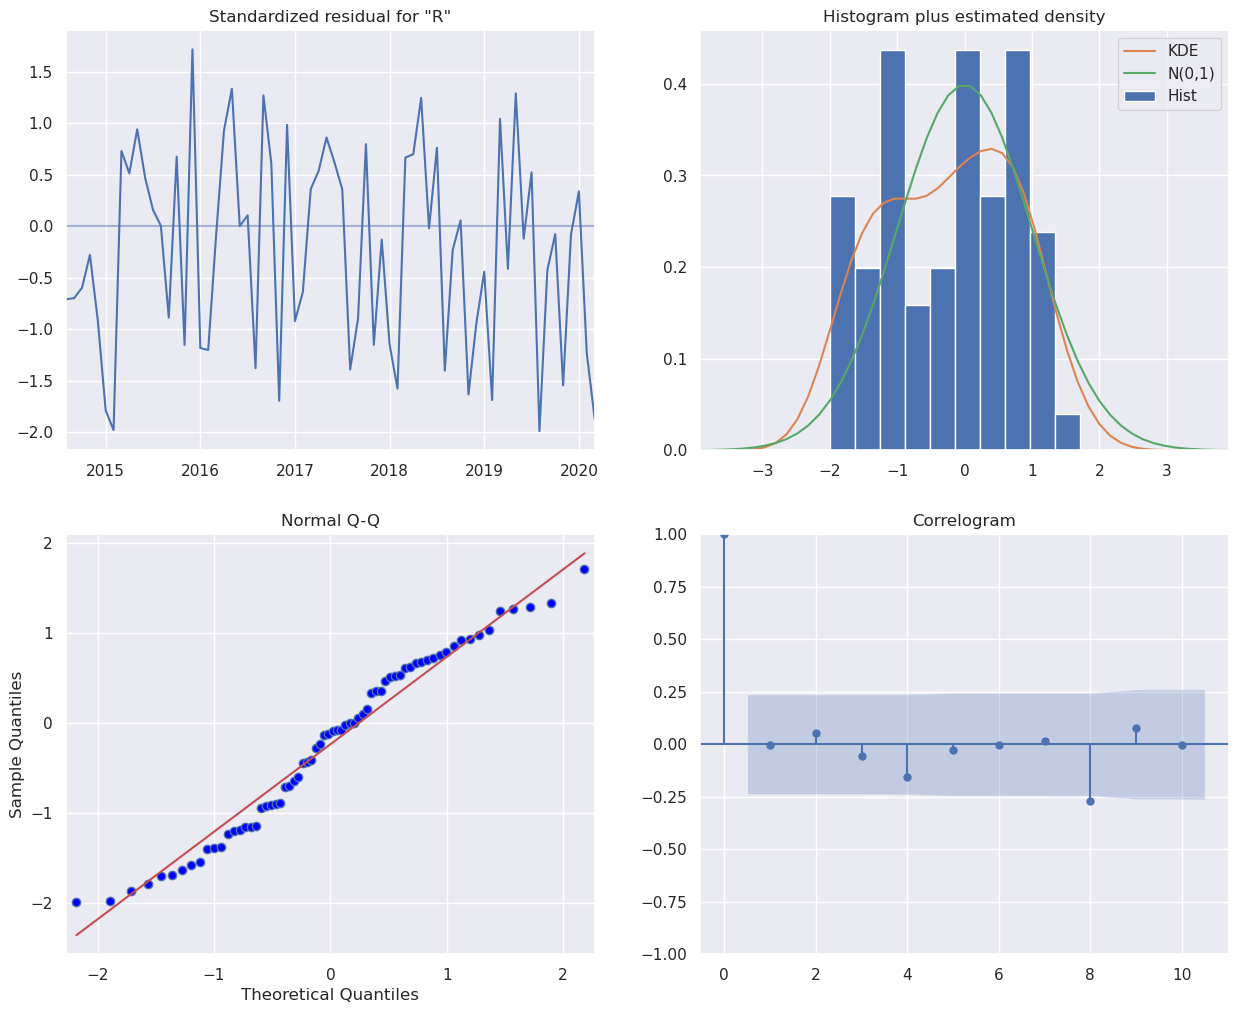

In [29]:
result.plot_diagnostics(figsize=(15, 12)) #Plot diagnostics
plt.show()

In [30]:
pred_apr = result.get_forecast(steps=4) #gets forecast for the next 4 months
pred_vcapr = pred_apr.conf_int() #confidence interval for evaluation

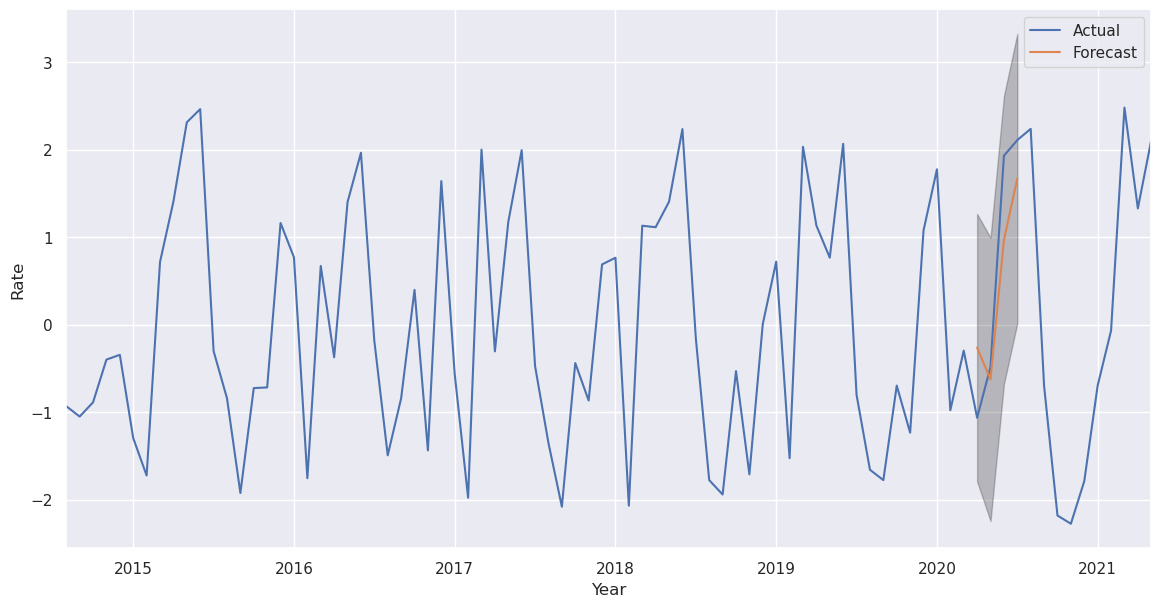

In [31]:
ax = dtrnd_vc.plot(label='Actual', figsize=(14, 7))
#     print(pred_apr.predicted_mean)
pred_apr.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_vcapr.index,
                pred_vcapr.iloc[:, 0],
                pred_vcapr.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel(dtrnd_vc.name)

plt.legend()
plt.show()

***
The plot shows the forecasted values plotted against the actual values, with the grey shading representing the upper and lower bounds (possible values).

For **April 2020**, it shows that actual crime levels fell lower than the predicted but both levels start to rise with the actual levels getting higher than the predicted for the remainder of the lockdown period. 

**Significant changes did occur** as results from the graph above and forecasted table below show that although crime levels fell at the start of the lockdown, it significantly rose for the rest of the period peaking in July, 2020 unlike for previous years where crime levels drop around July.

***

In [32]:
# Produce the forecasted tables 
apr_pm = pred_apr.predicted_mean.reset_index()
apr_pm.columns = ['Date','Predicted_Mean']
p_vcapr = pred_vcapr.reset_index()
p_vcapr.columns = ['Date','Lower Bound','Upper Bound']

apr = apr_pm.join(p_vcapr.set_index('Date'), on='Date') 
apr_table= apr.merge(vc_to_test, left_on='Date', right_on='Month', how='inner')
apr_table

,Date,Predicted_Mean,Lower Bound,Upper Bound,Rate
0,2020-04-01,-0.26304650,-1.79082113,1.26472813,-1.06348330
1,2020-05-01,-0.62505488,-2.24302665,0.99291688,-0.48326428
2,2020-06-01,0.96532791,-0.67971618,2.61037200,1.92885744
3,2020-07-01,1.66916423,0.01580926,3.32251920,2.10788380


***
##### EVALUATION
For the purpose of evaluation, two metrices were used. **RMSE**(Root Mean Square Error) which is the standard deviation of the residuals (prediction errors) and **MAE**(Mean Absolute Error) which is the mean of the absolute values of the individual prediction errors on over all instances in the test set.
***

###### RMSE
There is no standard for RMSE, only that the lower the value, the better fit a model is to a dataset. The range of values also helps in determining if an RMSE value is a good model. For a normalised dataset, a value closer to 0 represents a better fitting model (Alita, Putra and Darwis, 2021).

In [33]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse(apr_table['Predicted_Mean'], apr_table['Rate'])

0.6673956207403486

###### MAE
A good MAE is relative to the dataset just like RMSE, a value closer to 0 suggests a better fitting model (Rahman and Ahmar, 2017).

In [34]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(apr_table['Rate'], apr_table['Predicted_Mean'])

0.586119126662616

Results obtained from the evaluation methods show an RMSE value of 0.67 which is closer to 1 than 0. The MAE value however is 0.59, although lower than the RMSE, it is still closer to 1 than 0. This values signify an 'OK' model meaning that the model may not be best fitting.

***
### LEICESTER LOCKDOWN FINDINGS
***

In [35]:
#loading all_crimes data into a dataframe

url = "http://unn-izje1.newnumyspace.co.uk/LSOA_pop_v2.csv"
spark.sparkContext.addFile(url)

In [36]:
#Defining a new schema rather than using the one inferred 

lsoa_schema = StructType(
    [
        StructField('Date', StringType(),False),
        StructField('Geography', StringType(),False),
        StructField('Geo_ID', StringType(),False),
        StructField('Address_Type', StringType(),False),
        StructField('All_Res', StringType(),False),
        StructField('Males', StringType(),False),
        StructField('Females', StringType(),False),
        StructField('Household', StringType(),False),
        StructField('Commune', StringType(),False),
        StructField('Sch_full', StringType(),False),
        StructField('Area', StringType(),False),
        StructField('Density', StringType(),False)
    ]
)

In [37]:
#loading dataframe with new schema
lsoa_df = spark.read.csv("file://" + SparkFiles.get("LSOA_pop_v2.csv"), header=True, schema= lsoa_schema)

***
A new dataframe containing violent crimes data from only Leicester Region of the UK was created by joining the all_crimes dataset to the location dataset on 'LSOACode' and 'Geo_ID'. It is to be used in the evaluation of crime rates in Leicester for the period of their lockdown which started in July,2020.
***

In [38]:
leicester_df_vc = (AC_df.join(lsoa_df, ((AC_df['LSOACode'] == lsoa_df['Geo_ID']))) #joining the dataframes
    .select(AC_df.Month, AC_df['CrimeType'], AC_df['LSOACode'], lsoa_df.Geography)
    .where(AC_df.CrimeType == 'Violence and sexual offences')
    .filter(lsoa_df.Geography.contains("Leicester"))
    .groupby("Month")
    .agg(count("CrimeType").alias("Rate"))
    .orderBy("Month"))

In [39]:
leicester_pd = leicester_df_vc.toPandas() #converting to a pandas dataframe

In [40]:
leicester_pd.Month = leicester_pd.Month.astype('datetime64[ns]')#converting to pandas datetime index
leicester_pd = leicester_pd.set_index(pd.to_datetime(leicester_pd.Month))

***
In the plot below, not much change is seen in 2013-2014 where the crime levels are averaging around 600. Crime levels are seen to keep rising from 2015 to 2021. A major incline is noticed from March to July 2020 where the levels gradually start to decline.
***

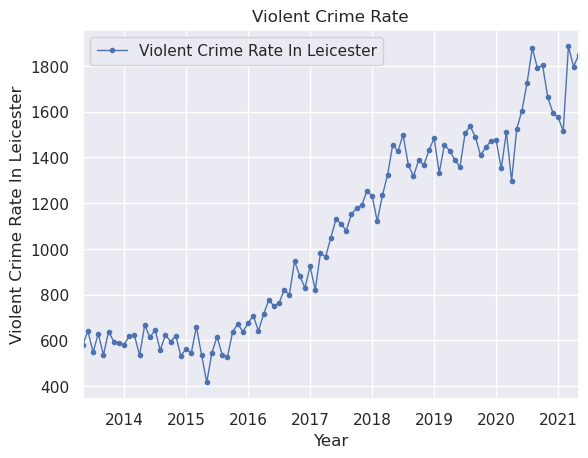

In [41]:
plt.figsize=(20, 6)

leicester_pd.plot(y='Rate', x='Month',marker='.', linestyle='-', linewidth=1,\
         subplots=False,
              label='Violent Crime Rate In Leicester',
              title='Violent Crime Rate')
plt.ylabel('Violent Crime Rate In Leicester')
plt.xlabel('Year')

plt.show() #displays graph of violent crime rates in Leicester

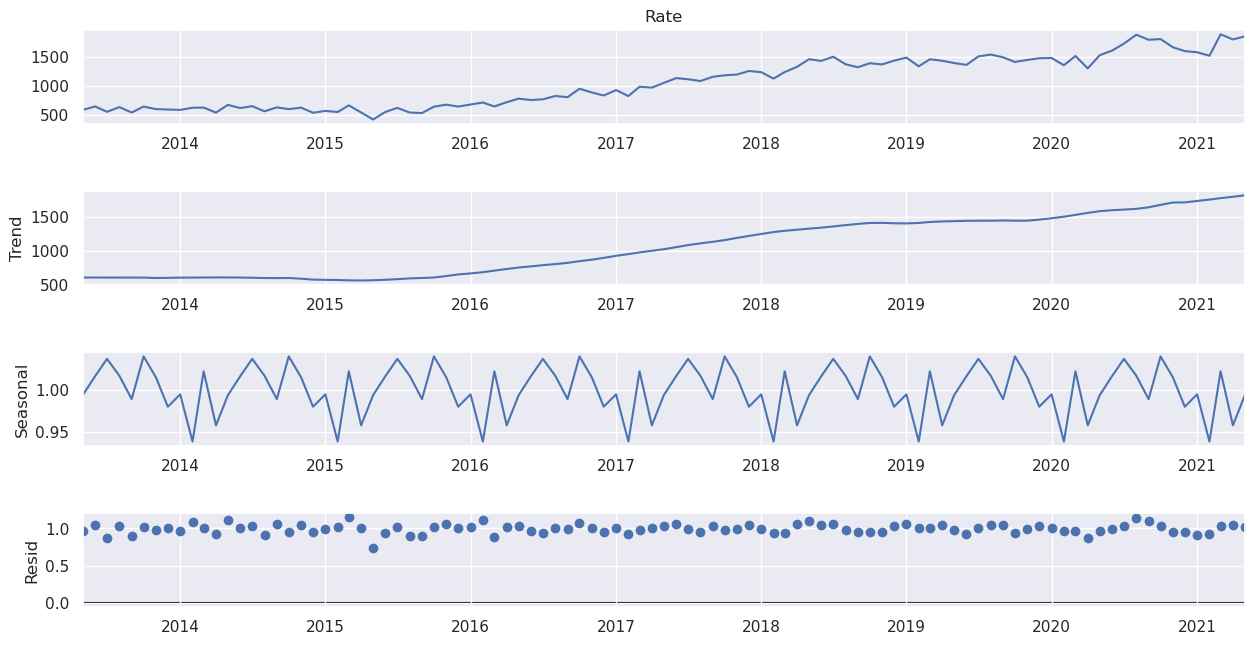

In [42]:
#decomposing leicester series
decomposition_lei = sm.tsa.seasonal_decompose(leicester_pd['Rate'], model='multiplicative',extrapolate_trend='freq')
#multiplicative model is used because the seasonal component changes over time.
fig = decomposition_lei.plot()
fig.set_size_inches(14,7)
plt.show()

<Figure size 640x480 with 0 Axes>

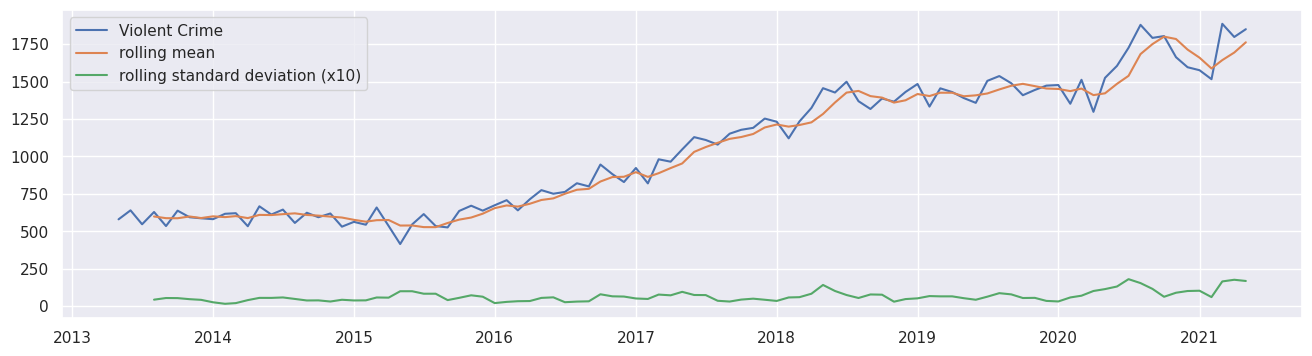

 > Is the raw data stationary ?
Test statistic = 0.085
P-value = 0.965
Critical values :
	1%: -3.5011373281819504 - The data is not stationary with 99% confidence
	5%: -2.8924800524857854 - The data is not stationary with 95% confidence
	10%: -2.5832749307479226 - The data is not stationary with 90% confidence


In [43]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(leicester_pd['Rate'],'Violent Crime')
ADF_test(leicester_pd['Rate'],'raw data')

Stationarity tests show that the series is not stationary as the test-statistic is greater than all critical values and p-value is greater than significant value.

<Figure size 640x480 with 0 Axes>

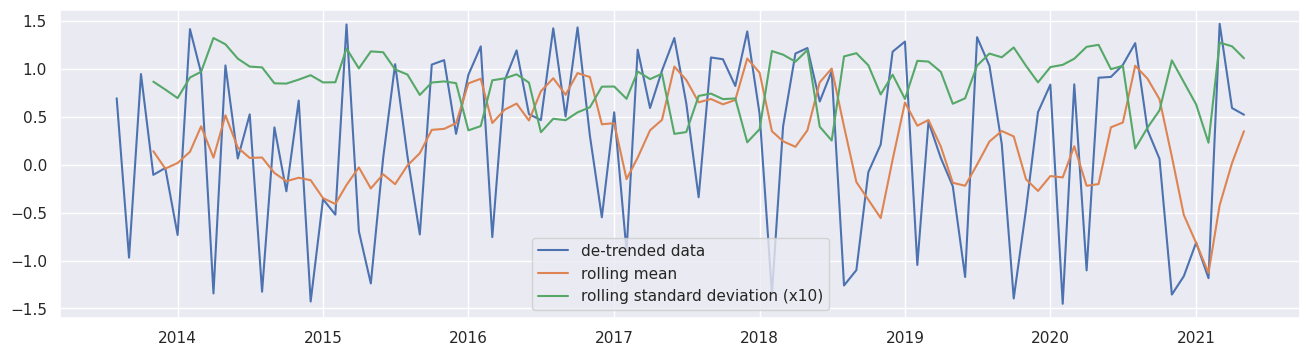

 > Is the de-trended data stationary ?
Test statistic = -9.171
P-value = 0.000
Critical values :
	1%: -3.502704609582561 - The data is  stationary with 99% confidence
	5%: -2.8931578098779522 - The data is  stationary with 95% confidence
	10%: -2.583636712914788 - The data is  stationary with 90% confidence


In [44]:
# Detrending
Leicester = leicester_pd['Rate']
Leicester_detrend =  (Leicester - Leicester.rolling(window=4).mean())/Leicester.rolling(window=4).std()

test_stationarity(Leicester_detrend,'de-trended data')
ADF_test(Leicester_detrend,'de-trended data')
#series is stationary.

Series is now stationary

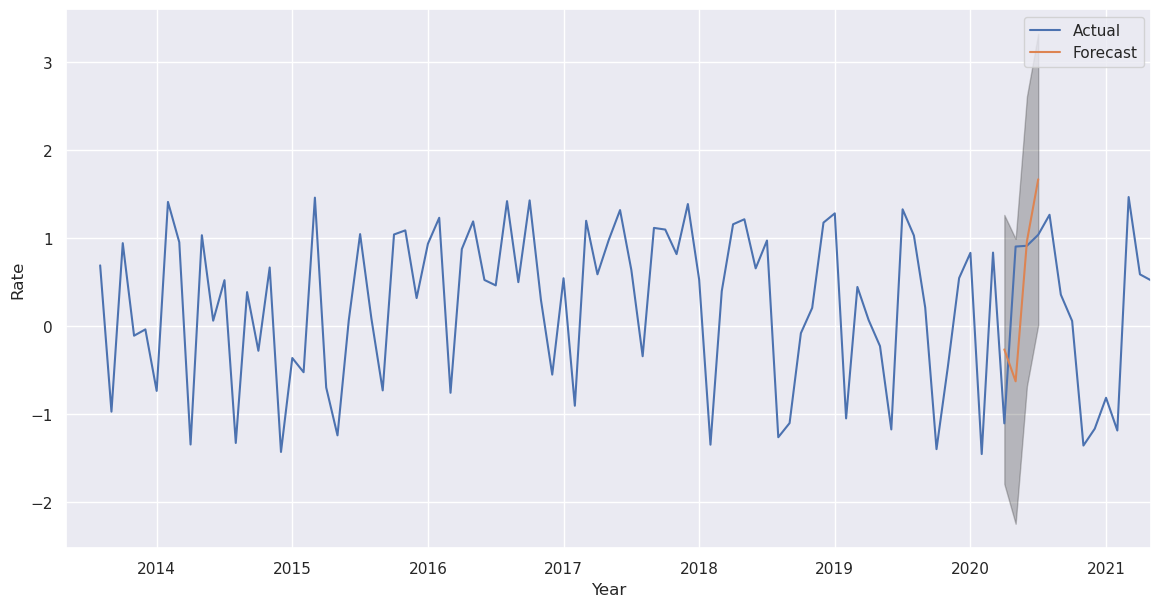

In [45]:
lei = Leicester_detrend.plot(label='Actual', figsize=(14, 7))
#     print(pred_apr.predicted_mean)
pred_apr.predicted_mean.plot(ax=lei, label='Forecast')
lei.fill_between(pred_vcapr.index,
                pred_vcapr.iloc[:, 0],
                pred_vcapr.iloc[:, 1], color='k', alpha=.25)
lei.set_xlabel('Year')
lei.set_ylabel(Leicester_detrend.name)

plt.legend()
plt.show()

***
The plot above and forecasted table below show the forecasted crime rate against the actual violent crime rates in Leicester. Leicester had their lockdown in July, 2020 and the actual crime rates in July are a lot less than the forecasted rates. 
From the graph, it is seen that the crime rates for the locdown period reached its peak in August and gradually started to drop till it hit a low in December.

The results for Leicester pose to be a little different from the results obtained from the analysis done on the whole of UK. As for Leicester, the peak was in August, a month after the lockdown started but for the rest of UK the peak was seen in July.
***

In [46]:
july_lockdown  = Leicester_detrend.loc['2020-07':] #from july 2020

In [47]:
lei_lckdwn_table = apr.merge(july_lockdown, left_on='Date', right_on='Month', how='inner')
lei_lckdwn_table

,Date,Predicted_Mean,Lower Bound,Upper Bound,Rate
0,2020-07-01,1.66916423,0.01580926,3.32251920,1.03952459


##### EVALUATION

###### RMSE

In [48]:
rmse(lei_lckdwn_table['Predicted_Mean'], lei_lckdwn_table['Rate'])

0.6296396425305393

###### MAE

In [49]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(lei_lckdwn_table['Rate'], lei_lckdwn_table['Predicted_Mean'])

0.6296396425305393


The results from the evaluations show that although the model produced an almost accurate prediction it may not be the best fit for this analysis. 


*** 
## CONCLUSION
The Covid-19 was not only dangerous to health but it also led to the implementation of lockdowns, which put victims in the same room as their assaulters. The goal of this project was to see if the UK's lockdown resulted in an overall increase in reported violent crimes.

The violent crime data shows a gradual increase in crime levels, with minor dips in intervals. For the period of the lockdown (March 16th - July 3rd, 2020) there is a significant decrease in crime rates at the beginning, but there is an incline at the end of the period. Time series analysis (forecasting) was performed on violent crime data from before UK's lockdown, the analysis was done to predict crime levels for the lockdown. It forecasted that the crime rates would drop slightly in April but would keep increasing from May -July with July having the highest violent crime levels but actual crime levels fell at the start of the lockdown and started to rise for the rest of the period peaking in July. 

From the analysis done, it is seen that the lockdown did cause a significant increase in recorded violent crimes as for that period as it can be noticed that the peak was hit during the lockdown. 
***

***
### REFERENCES
* Alita, D., Putra, A.D. and Darwis, D., 2021. Analysis of classic assumption test and multiple linear regression coefficient test for employee structural office recommendation. IJCCS (Indonesian Journal of Computing and Cybernetics Systems), 15(3).
* Amimour, A. and Belaide, K., 2020. A long memory time series with a periodic degree of fractional differencing. arXiv preprint arXiv:2008.01939.
* Arenas-Arroyo, E., Fernandez-Kranz, D., Nollenberger, N. (2021). 'Intimate partner violence under forced cohabitation and economic stress: Evidence from the COVID-19 pandemic', *Journal of Public Economics, Vol 194* https://www.sciencedirect.com/science/article/pii/S0047272720302140
* Bai, Z., Choi, K.P. and Fujikoshi, Y., 2018. Consistency of AIC and BIC in estimating the number of significant components in high-dimensional principal component analysis. The Annals of Statistics, 46(3), pp.1050-1076.
* Busetti, F. and Taylor, A.R., 2004. Tests of stationarity against a change in persistence. Journal of Econometrics, 123(1), pp.33-66.
* Chang, T., Hsu, C.M. and Wang, M.C., 2021. Bubbles During Covid-19 Period: Evidence from the United States Using the Generalized Sub ADF Test. HOLISTICA–Journal of Business and Public Administration, 12(1), pp.49-56.
* Chiarella, C., He, X.Z. and Hommes, C., 2006. A dynamic analysis of moving average rules. Journal of Economic Dynamics and Control, 30(9-10), pp.1729-1753.
* Das A., Das M., Ghosh S. (2020). 'Impact of nutritional status and anemia on COVID-19-is it a public health concern? Evidence from national family health' survey-4, India. *Public Health*.  
* Montgomery, D.C., Jennings, C.L. and Kulahci, M., 2015. Introduction to time series analysis and forecasting. John Wiley & Sons.
* Musbah, H. and El-Hawary, M., 2019, May. SARIMA Model Forecasting of Short-Term Electrical Load Data Augmented by Fast Fourier Transform Seasonality Detection. In 2019 IEEE Canadian Conference of Electrical and Computer Engineering (CCECE) (pp. 1-4). IEEE.
* Nielsen, A., 2019. Practical time series analysis: Prediction with statistics and machine learning. O'Reilly Media.
* Peterman, A., Potts, A., Donnell, O. M., Shah, N., Oertelt-prigione, S., Van Gelder, N. (2020). 'Pandemics and violence against women and children'. *Center for Global Development Working Paper, 43*. https://www.cgdev.org/publication/pandemics-and-violence-against-women-and-children.
* Poblete-Cazenave, R. (2020). 'The impact of Lockdowns on crime and violence against women - Evidence from India'.Available at SSRN: https://ssrn.com/abstract=3623331 
* Rahman, A. and Ahmar, A.S., 2017, September. Forecasting of primary energy consumption data in the United States: A comparison between ARIMA and Holter-Winters models. In AIP Conference Proceedings (Vol. 1885, No. 1, p. 020163). AIP Publishing LLC.
* Schüler, Y.S., 2018. Detrending and financial cycle facts across G7 countries: Mind a spurious medium term!.
* Theodosiou, M., 2011. Disaggregation & aggregation of time series components: A hybrid forecasting approach using generalized regression neural networks and the theta method. Neurocomputing, 74(6), pp.896-905.
***

In [50]:
end_time = dt.now()
time_elapsed = end_time - start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Time elapsed (hh:mm:ss.ms) 0:20:04.122809
